##### Working with AIA and XRT data in python to get the DEM via regularisation

So far just AIA and XRT for the 12 Sep 2020 event
- 26-04-2021 IGH
- 20-05-2021 IGH -> Corrected XRT response/data change (x2 on response)
- 11-06-2021 IGH -> This one just focuses on XRT and AIA now
- 16-06-2021 IGH -> Update to use newly updated demregpy code
- 17-06-2021 IGH -> Updated the AIA/XRT error estimate, comparing to sswidl (where I can)
- 05-05-2022 IGH -> Updated for newer demreg code

***Results for this sort of data (from cells below)***
- Best doing EMD_int=True
- gloci=0 for AIA only, gloci=1 for AIA+XRT
- Really need the XRT*2 -> real check is with NuSTAR
- 20% uncertainty probably min, due to systematics between instruments and accuracy of responses

In [1]:
# Import some of the stuff we might need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import scipy.io as io
import glob

from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

import astropy.time
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Load in the XRT data and grade map for the Sep 2020 data from sswidl make_xrt_for_python.pro

fdata='XRT_20200912_204028_Be_thin_Open_512.fits'
fgm='gm_XRT_20200912_204028_Be_thin_Open_512.fits'

xmap=sunpy.map.Map(fdata)
xgmmap=sunpy.map.Map(fgm)


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


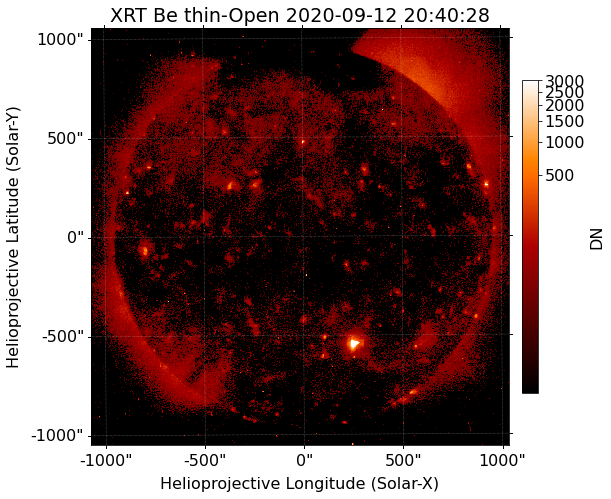

In [3]:
#  Plot the map to check looks ok
dmin=3
dmax=3e3

fig = plt.figure(figsize=(8, 8))
xmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


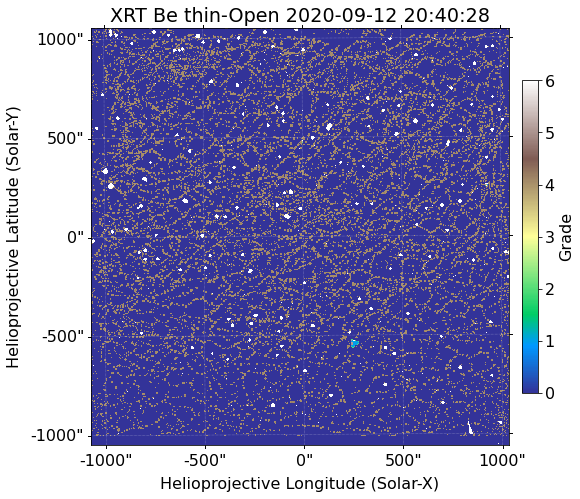

In [4]:
# Plot the grade map
fig = plt.figure(figsize=(8, 8))
xgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


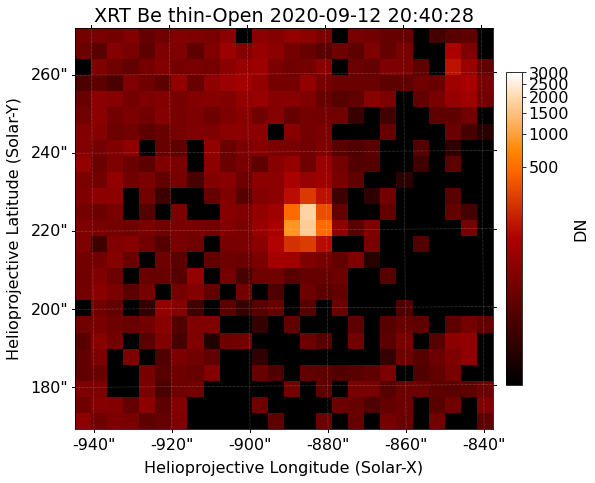

In [5]:
# Submap closer to the region of interest
bl=[-940*u.arcsec, 170*u.arcsec]
tr=[-840*u.arcsec, 270*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
sxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
sxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


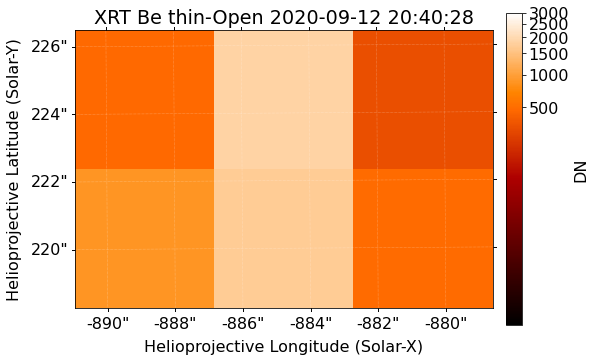

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


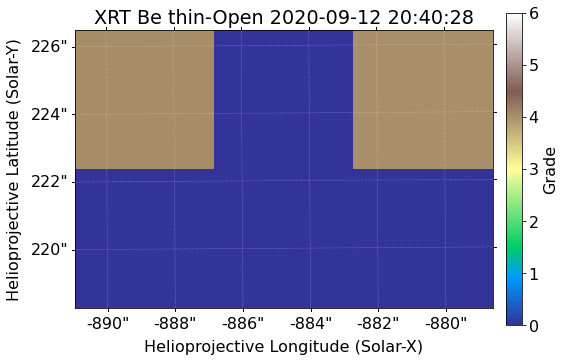

In [6]:
#  Get the XRT for just the region of interest
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
regxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

dmin=3
dmax=3e3
fig = plt.figure(figsize=(8, 8))
regxmap.plot(norm=colors.PowerNorm(gamma=0.2,vmin=dmin,vmax=dmax))
plt.colorbar(fraction=0.035, pad=0.03,label='DN')
plt.show()

# Same for the grade map showing some grade 4 near feature => contamination spots
regxgmmap = xgmmap.submap(bottom_left=bottom_left, top_right=top_right)
fig = plt.figure(figsize=(8, 8))
regxgmmap.plot(norm=colors.Normalize(vmin=0,vmax=6),cmap='terrain')
plt.colorbar(fraction=0.035, pad=0.03,label='Grade')
plt.show()


In [7]:
#  What is the DN/s/px from the region???
dur=regxmap.exposure_time.value
# What pixel binning per dimension
chipsum=regxmap.meta['chip_sum']
#  Get a DN/s/px (non-binned pixels) for the region
xdnspx=np.mean(regxmap.data)/dur/chipsum**2
print(xdnspx, ' DN/s/px')

3.60276666469872  DN/s/px


In [8]:
# #  Now prep and get the AIA values
# #  Do all the prep first and save out the submaps
# ffa=sorted(glob.glob('aia.lev1*.fits'))
# # print(ffa)

# amaps=sunpy.map.Map(ffa)
# # Get the wavelengths of the maps, get index of sort for this list of maps and reorder
# wvn0 = [m.meta['wavelnth'] for m in amaps]
# srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
# amaps = [amaps[i] for i in srt_id]
# print([m.meta['wavelnth'] for m in amaps])

# # aiaprep the images, may take a while to run
# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m)
#     aprep.append(register(m_temp))
# #  Just save out the prepped submaps to quickly load in later
# for m in aprep:
#     bottom_left = SkyCoord(-940*u.arcsec,170*u.arcsec, frame=m.coordinate_frame)
#     top_right = SkyCoord(-840*u.arcsec,270*u.arcsec, frame=m.coordinate_frame)
#     mm = m.submap(bottom_left=bottom_left, top_right=top_right)
#     wvn="{0:d}".format(1000+mm.meta['wavelnth'])
#     wvn=wvn[1:]
#     mm.save('maps_prep_092021_'+wvn+'.fits',overwrite='True')



In [9]:
ffp=sorted(glob.glob('maps_prep_092021*.fits'))
aprep=sunpy.map.Map(ffp)

In [10]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
durs = [m.meta['exptime'] for m in aprep]
# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.902044 2.901345 2.000162 1.999637 2.90119  2.900818]
[ 94 131 171 193 211 335]


3.15375e+17


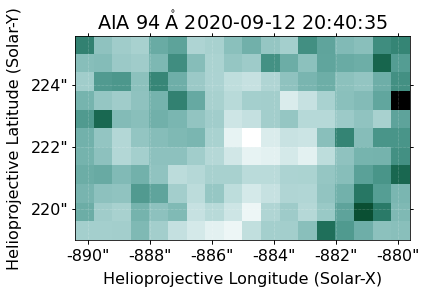

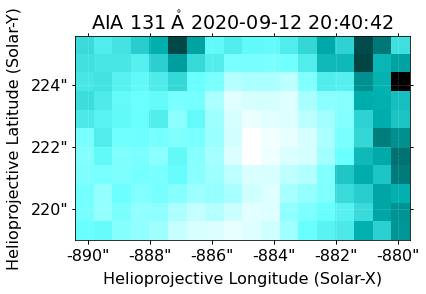

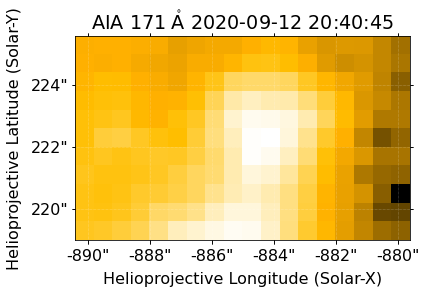

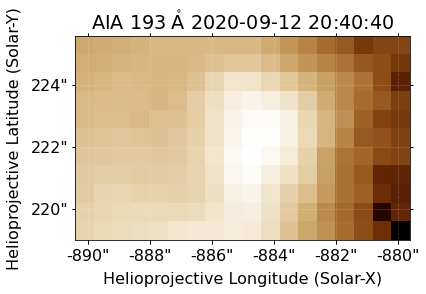

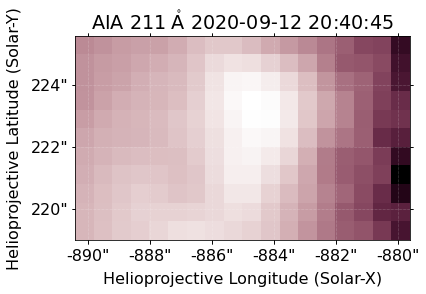

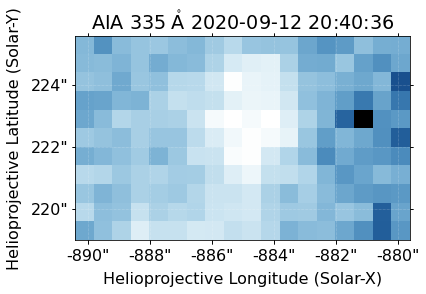

[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]


In [11]:
# Use the XRT region from above
# This is just a rough example so will need to refine these - got the correct AIA feature?
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]

area=(tr[0].value-bl[0].value)*(tr[1].value-bl[1].value)*7.25e7*7.25e7  
print(area)

data_mean = []
num_pix = []
for m in aprep:
    bottom_left = SkyCoord(bl[0],bl[1], frame = m.coordinate_frame)
    top_right = SkyCoord(tr[0],tr[1], frame=m.coordinate_frame)
    sub_temp = m.submap(bottom_left=bottom_left, top_right=top_right)
    data_mean.append(np.mean(sub_temp.data))
    num_pix.append(sub_temp.data.size)
    sub_temp.plot()
    plt.show()
print(data_mean)

In [12]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=astropy.time.Time('2020-09-12T20:40:00', scale='utc')

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time)#,calibration_version=10)
# print(degs)

# As slow to compute here's the previously calculated for the above
degs=np.array([0.90317732, 0.50719532, 0.73993289, 0.49304311, 0.40223458, 0.17221724])
print(degs)

[0.90317732 0.50719532 0.73993289 0.49304311 0.40223458 0.17221724]


In [13]:
#  Correct the AIA data for the degradation
cor_data=data_mean/degs
print(data_mean)
print(cor_data)

# Get into DN/s/px for the DEM stuff
adn_in=cor_data/durs
print('DN/s/px: ',adn_in)

[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]
[   6.28539899   72.38914944  915.33872041 1153.58967666  594.35890401
   39.44888671]
DN/s/px:  [  2.16585241  24.95020394 457.63229199 576.8995456  204.86727998
  13.59922846]


In [14]:
#  Load in the AIA responses from sswidl make_aiaresp_forpy.pro
trin=io.readsav('aia_tresp_en.dat')

for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
# print(trin['channels'])
chans=np.array(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,7))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

In [15]:
#  Load in the XRT ones from sswidl make_xrt_tresp_forpy.pro
tr_sep20=io.readsav('xrt_tresp_20200912.dat')

filters=np.array(tr_sep20['filters'])
filters[0]=filters[0].decode('utf-8')
filters[1]=filters[1].decode('utf-8')
# print(filters)
units=tr_sep20['units'].decode('utf-8')
# print(units)
# date_sep20=astropy.time.Time(tr_sep20['date'].decode('utf-8'), format = 'isot')
# print(date_sep20.iso[:10])

In [16]:
#  Combine the AIA and XRT together
chanax=np.append(chans,filters[1])
print(chanax)
xtrint=10**np.interp(tresp_logt,tr_sep20['logt'],np.log10(tr_sep20['tr'][1]))
trmatrix[:,6]=xtrint

['A94' 'A131' 'A171' 'A193' 'A211' 'A335' 'Be-thin']


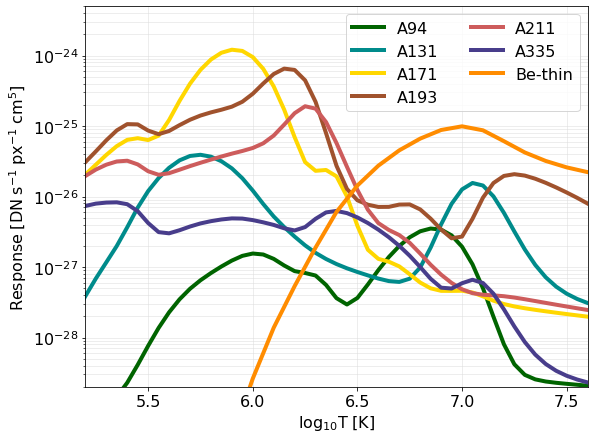

In [17]:
# Setup some colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','darkorange']

# Do the plot
fig = plt.figure(figsize=(9, 7))
for i in np.arange(7):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=chanax[i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.2,7.6])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

In [18]:
# Now combine the AIA and XRT data together
dn_in=np.append(adn_in,xdnspx)
print(dn_in)
# Lets just assume some % error
edn_in=0.1*np.copy(dn_in)
print(edn_in)

[  2.16585241  24.95020394 457.63229199 576.8995456  204.86727998
  13.59922846   3.60276666]
[ 0.21658524  2.49502039 45.7632292  57.68995456 20.486728    1.35992285
  0.36027667]


AIA , $\chi^2 =$ 1.02
AIA G_EMD, $\chi^2 =$ 1.03
AIA+XRT , $\chi^2 =$ 25.34
AIA+XRT G_EMD, $\chi^2 =$ 3.43
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
AIA+XRT2 , $\chi^2 =$ 38.88
AIA+XRT2 G_EMD, $\chi^2 =$ 4.99


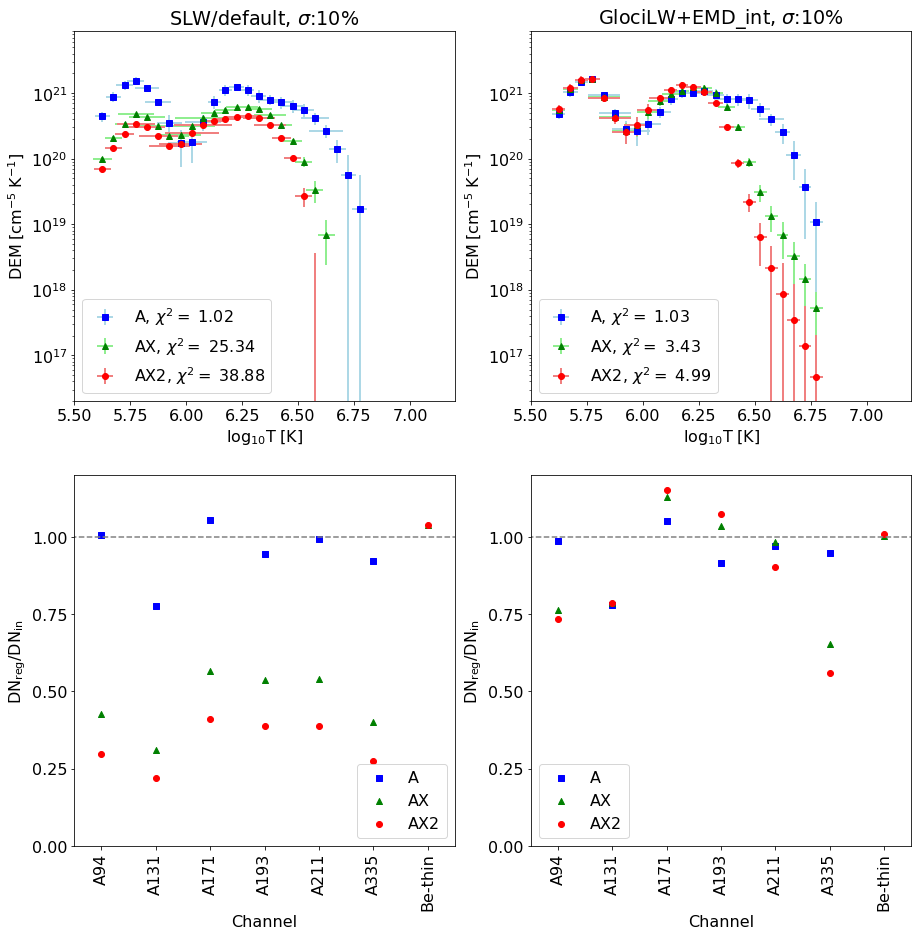

In [19]:
# Now do the DEMs, with only AIA, then AIA+XRT
# Do default, gloci+EMD_int

# Temperature binning to use
mint=5.6
maxt=6.8
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Do a 10% uncertainty
edn_in=0.1*np.copy(dn_in)

# AIA only
dema,edema,elogta,chisqa,dn_rega\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps)
print('AIA , $\chi^2 =$ {:0.2f}'.format(chisqa))
dema1,edema1,elogta1,chisqa1,dn_rega1\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps,gloci=1,emd_int=True)
print('AIA G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqa1))
# AIA + XRT 
demax,edemax,elogtax,chisqax,dn_regax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)
print('AIA+XRT , $\chi^2 =$ {:0.2f}'.format(chisqax))
demax1,edemax1,elogtax1,chisqax1,dn_regax1\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax1))
# Now try it with the XRT response*2
# Wright et al. 2017 and Schmelz et al. 2015 did this via factor x2-3 of the XRT temperature response
# i.e. https://iopscience.iop.org/article/10.3847/1538-4357/aa7a59#apjaa7a59f8
trm2=np.copy(trmatrix)
trm2[:,6]=trm2[:,6]*2.0
demax02,edemax02,elogtax02,chisqax02,dn_regax02\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps)
print('AIA+XRT2 , $\chi^2 =$ {:0.2f}'.format(chisqax02))
demax12,edemax12,elogtax12,chisqax12,dn_regax12\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT2 G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax12))


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2,1)
plt.errorbar(mlogt,dema,xerr=elogta,yerr=edema,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa))
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax))
plt.errorbar(mlogt,demax02,xerr=elogtax02,yerr=edemax02,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax02))
plt.title('SLW/default, $\sigma$:10%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax2 = fig.add_subplot(2, 2,2)
plt.errorbar(mlogt,dema1,xerr=elogta1,yerr=edema1,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa1))
plt.errorbar(mlogt,demax1,xerr=elogtax1,yerr=edemax1,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax1))
plt.errorbar(mlogt,demax12,xerr=elogtax12,yerr=edemax12,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax12))
plt.title('GlociLW+EMD_int, $\sigma$:10%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax3 = fig.add_subplot(2, 2,3)
plt.scatter(np.arange(6),dn_rega/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax02/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()

ax4 = fig.add_subplot(2, 2,4)
plt.scatter(np.arange(6),dn_rega1/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax1/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax12/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()


AIA , $\chi^2 =$ 7.59
AIA G_EMD, $\chi^2 =$ 0.96
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
AIA+XRT , $\chi^2 =$ 38.83
AIA+XRT G_EMD, $\chi^2 =$ 3.42
Warning, positivity loop hit max iterations, so increase max_iter? Or rgt_fact too small?
AIA+XRT2 , $\chi^2 =$ 38.01
AIA+XRT2 G_EMD, $\chi^2 =$ 7.46


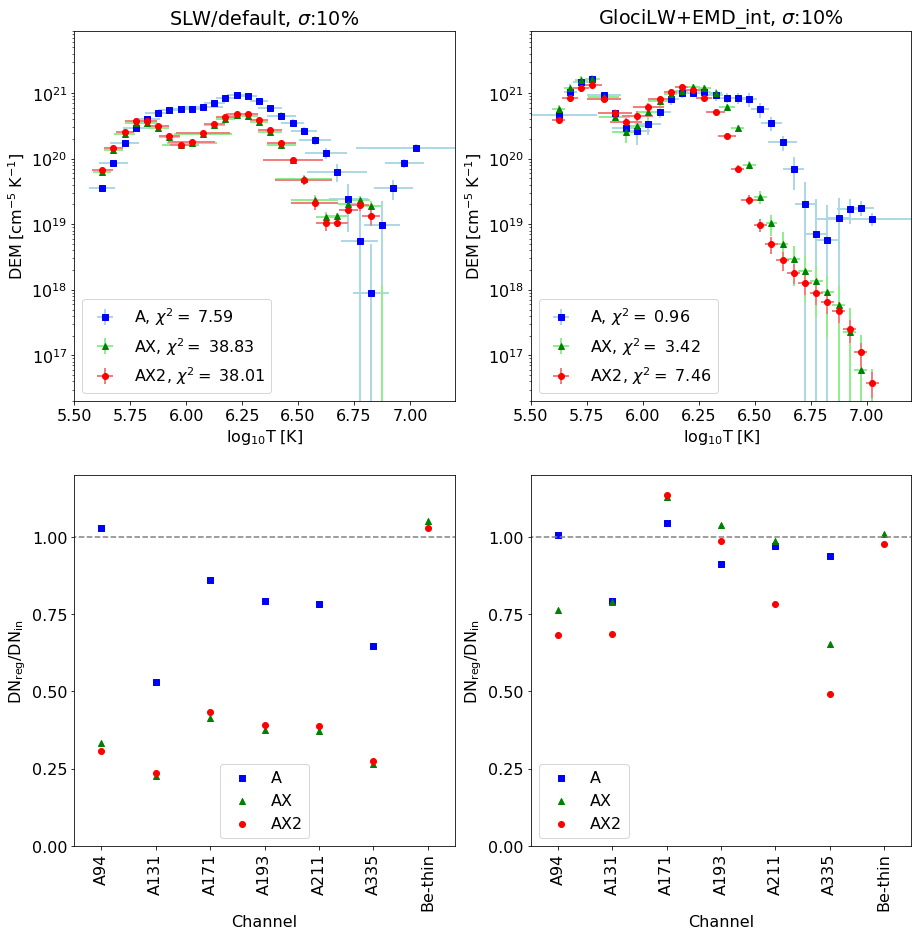

In [20]:
# Now do the DEMs, with only AIA, then AIA+XRT
# Do default, gloci+EMD_int

# Change T range
mint=5.6
maxt=7.0
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Do a 10% uncertainty
edn_in=0.1*np.copy(dn_in)

# AIA only
dema,edema,elogta,chisqa,dn_rega\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps)
print('AIA , $\chi^2 =$ {:0.2f}'.format(chisqa))
dema1,edema1,elogta1,chisqa1,dn_rega1\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps,gloci=1,emd_int=True)
print('AIA G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqa1))
# AIA + XRT 
demax,edemax,elogtax,chisqax,dn_regax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)
print('AIA+XRT , $\chi^2 =$ {:0.2f}'.format(chisqax))
demax1,edemax1,elogtax1,chisqax1,dn_regax1\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax1))
# Now try it with the XRT response*2
# Wright et al. 2017 and Schmelz et al. 2015 did this via factor x2-3 of the XRT temperature response
# i.e. https://iopscience.iop.org/article/10.3847/1538-4357/aa7a59#apjaa7a59f8
trm2=np.copy(trmatrix)
trm2[:,6]=trm2[:,6]*2.0
demax02,edemax02,elogtax02,chisqax02,dn_regax02\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps)
print('AIA+XRT2 , $\chi^2 =$ {:0.2f}'.format(chisqax02))
demax12,edemax12,elogtax12,chisqax12,dn_regax12\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT2 G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax12))


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
plt.errorbar(mlogt,dema,xerr=elogta,yerr=edema,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa))
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax))
plt.errorbar(mlogt,demax02,xerr=elogtax02,yerr=edemax02,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax02))
plt.title('SLW/default, $\sigma$:10%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax2 = fig.add_subplot(2, 2, 2)
plt.errorbar(mlogt,dema1,xerr=elogta1,yerr=edema1,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa1))
plt.errorbar(mlogt,demax1,xerr=elogtax1,yerr=edemax1,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax1))
plt.errorbar(mlogt,demax12,xerr=elogtax12,yerr=edemax12,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax12))
plt.title('GlociLW+EMD_int, $\sigma$:10%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax3 = fig.add_subplot(2, 2, 3)
plt.scatter(np.arange(6),dn_rega/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax02/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()

ax4 = fig.add_subplot(2, 2,4)
plt.scatter(np.arange(6),dn_rega1/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax1/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax12/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()

# ax4 = fig.add_subplot(2, 2,4)
# plt.scatter(np.arange(6),(dn_in[0:6]-dn_rega1)/edn_in[0:6],marker='s',color='blue',label='A')
# plt.scatter(np.arange(7),(dn_in-dn_regax1)/edn_in,marker='^',color='green',label='AX')
# plt.scatter(np.arange(7),(dn_in-dn_regax12)/edn_in,marker='o',color='red',label='AX2')
# plt.plot([-1,12],[0,0],'--',color='grey')
# plt.ylim([-5,5])
# plt.xlim([-0.5,6.5])
# plt.xticks(np.arange(7),chanax,rotation=90)
# plt.xlabel('Channel')
# plt.ylabel('DN: (IN-REG)/ERR')
# plt.locator_params(axis='y', nbins=5)
# plt.legend()

plt.show()


AIA , $\chi^2 =$ 2.24
AIA G_EMD, $\chi^2 =$ 0.99
AIA+XRT , $\chi^2 =$ 25.00
AIA+XRT G_EMD, $\chi^2 =$ 1.00
AIA+XRT2 , $\chi^2 =$ 25.00
AIA+XRT2 G_EMD, $\chi^2 =$ 1.51


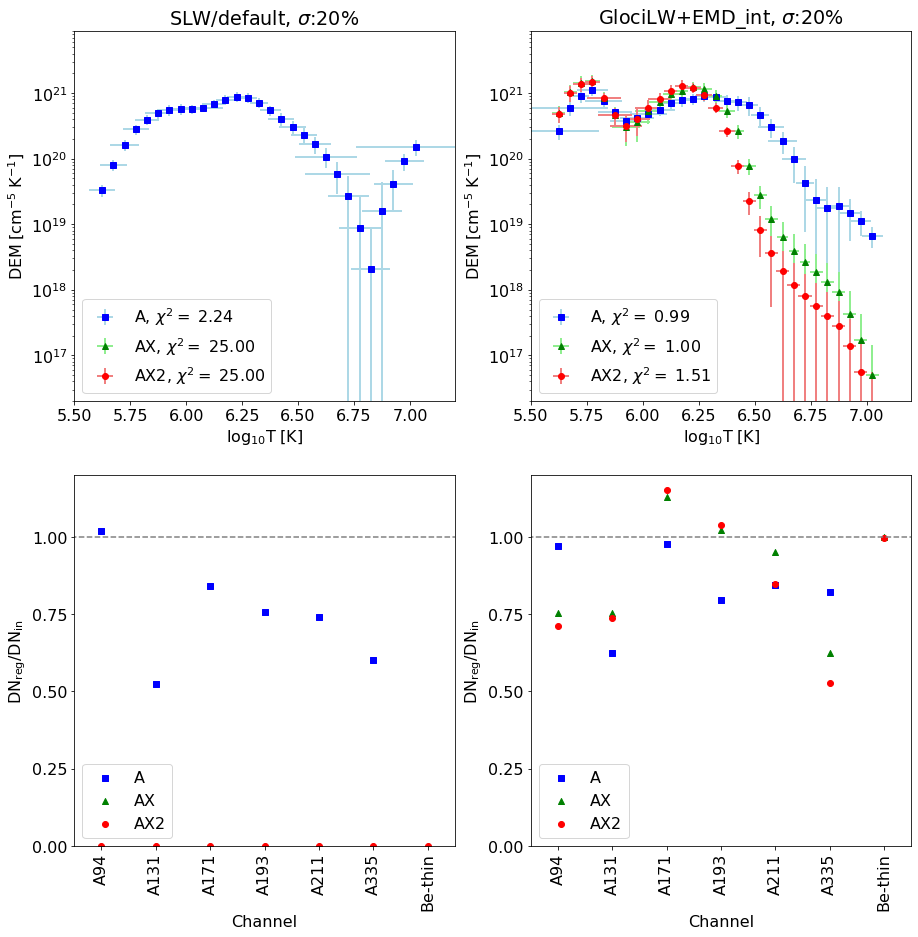

In [21]:
# Now do the DEMs, with only AIA, then AIA+XRT
# Do default, gloci+EMD_int

# Temperature binning to use
mint=5.6
maxt=7.0
dlogt=0.05
temps=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Do a 20% uncertainty
edn_in=0.2*np.copy(dn_in)

# AIA only
dema,edema,elogta,chisqa,dn_rega\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps)
print('AIA , $\chi^2 =$ {:0.2f}'.format(chisqa))
dema1,edema1,elogta1,chisqa1,dn_rega1\
    =dn2dem_pos(dn_in[0:6],edn_in[0:6],trmatrix[:,0:6],tresp_logt,temps,gloci=1,emd_int=True)
print('AIA G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqa1))
# AIA + XRT 
demax,edemax,elogtax,chisqax,dn_regax\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps)
print('AIA+XRT , $\chi^2 =$ {:0.2f}'.format(chisqax))
demax1,edemax1,elogtax1,chisqax1,dn_regax1\
    =dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax1))
# Now try it with the XRT response*2
# Wright et al. 2017 and Schmelz et al. 2015 did this via factor x2-3 of the XRT temperature response
# i.e. https://iopscience.iop.org/article/10.3847/1538-4357/aa7a59#apjaa7a59f8
trm2=np.copy(trmatrix)
trm2[:,6]=trm2[:,6]*2.0
demax02,edemax02,elogtax02,chisqax02,dn_regax02\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps)
print('AIA+XRT2 , $\chi^2 =$ {:0.2f}'.format(chisqax02))
demax12,edemax12,elogtax12,chisqax12,dn_regax12\
    =dn2dem_pos(dn_in,edn_in,trm2,tresp_logt,temps,gloci=1,emd_int=True)
print('AIA+XRT2 G_EMD, $\chi^2 =$ {:0.2f}'.format(chisqax12))


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2,1)
plt.errorbar(mlogt,dema,xerr=elogta,yerr=edema,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa))
plt.errorbar(mlogt,demax,xerr=elogtax,yerr=edemax,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax))
plt.errorbar(mlogt,demax02,xerr=elogtax02,yerr=edemax02,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax02))
plt.title('SLW/default, $\sigma$:20%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax2 = fig.add_subplot(2, 2,2)
plt.errorbar(mlogt,dema1,xerr=elogta1,yerr=edema1,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='A, $\chi^2 =$ {:0.2f}'.format(chisqa1))
plt.errorbar(mlogt,demax1,xerr=elogtax1,yerr=edemax1,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AX, $\chi^2 =$ {:0.2f}'.format(chisqax1))
plt.errorbar(mlogt,demax12,xerr=elogtax12,yerr=edemax12,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AX2, $\chi^2 =$ {:0.2f}'.format(chisqax12))
plt.title('GlociLW+EMD_int, $\sigma$:20%')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e16,9e21])
plt.xlim([5.5,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend(loc=3)

ax3 = fig.add_subplot(2, 2,3)
plt.scatter(np.arange(6),dn_rega/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax02/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()

ax4 = fig.add_subplot(2, 2,4)
plt.scatter(np.arange(6),dn_rega1/dn_in[0:6],marker='s',color='blue',label='A')
plt.scatter(np.arange(7),dn_regax1/dn_in,marker='^',color='green',label='AX')
plt.scatter(np.arange(7),dn_regax12/dn_in,marker='o',color='red',label='AX2')
plt.plot([-1,12],[1,1],'--',color='grey')
plt.ylim([0,1.2])
plt.xlim([-0.5,6.5])
plt.xticks(np.arange(7),chanax,rotation=90)
plt.xlabel('Channel')
plt.ylabel('DN$_\mathrm{reg}$/DN$_\mathrm{in}$')
plt.locator_params(axis='y', nbins=5)
plt.legend()
plt.show()


---

In [22]:
# Older testing where checking if uncertainties were ok

# Maybe something to do with the uncertainties -> so far just been using a 10%, 20% systematic
print('94: ',data_mean[0],'DN/px, ',num_pix[0],' pixels')
# AIA photon couting errors
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])

# Original DN/px value uncorrected from the AIA maps * num_pix to get original DN
aia_dn_org=np.array(data_mean)*np.array(num_pix)
aia_edn_org=(dn2ph*aia_dn_org)**0.5/dn2ph

print('shotnoise [%]: ',100.*aia_edn_org/aia_dn_org)
# print(data_mean[0],num_pix[0])
# So as averaging over larger area the AIA shotnoise (and other?) components small rel to systematics?

# Above just considering shotnoise, other components from sswidl code
# From https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/idl/response/aia_bp_estimate_error.pro
# 
# Try 94 as likely to be the noisest channel
# IDL> a=aia_bp_estimate_error(5.67683,94,n_sample=198,/loud) ;input/output in DN/px
#  Counts [DN]   RMS Error      SNR     Shot     Dark     Read    Quant Compress  Chianti Calibrat
#         5.68        0.31    18.31     0.24     0.18     0.08     0.02     0.00     0.00     0.00

# Main other ones:
# Dark is 0.18 irrespective of n_sample
# Readout is 1.15 / sqrt(n_sample)
# Quantum is 0.288819 / sqrt(n_sample)
# Noise terms given in DN, so to get DN/px need factor sqrt(n_sample)/n_sample = 1/sqrt(n_sample)

# So shotnoise the same (as it should be), and total slightly bigger overall but << systematics.

# Hopefully aiapy version will be available soon https://gitlab.com/LMSAL_HUB/aia_hub/aiapy/-/issues/60


94:  5.67683 DN/px,  198  pixels
shotnoise [%]:  [4.19153184 1.4236356  0.28929665 0.29224215 0.43110625 2.06957301]


In [23]:
# For XRT uncertainty estimate can use 
# https://hesperia.gsfc.nasa.gov/ssw/hinode/xrt/idl/response/j/xrt_cvfact.pro
# 
# In sswidl for Be-thin at time of obs
# IDL> te = 5.+findgen(61)*0.05
# IDL> cf = xrt_cvfact(te, 3, 0, '12-Sep-2020 20:40:00', /error)
# IDL> DN = 100.
# IDL> print, 'noise [DN]: ',sqrt(DN*cf)
# 
# Though this returns array as function of T, so not sure how to use this....
# Nothing similar for XRT as aia_bp_error_estimate.pro